<a href="https://colab.research.google.com/github/MasoudMoeini/Google-Street-View-Images-Blur-Detection/blob/main/SBDN_Expriment1_Shi_DUT_SZU_Concat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cv2
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential, Model,load_model
from keras.optimizers import gradient_descent_v2 
from google.colab.patches import cv2_imshow
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D
from keras.preprocessing import image
from keras.initializers import glorot_uniform
from keras import regularizers

In [2]:
!unzip -qq train.zip

In [3]:
from numpy import *
images_folder= "train/images/*.jpg"
labels_folder = "train/labels/"
def data_preprocessing(images_folder,labels_folder):
  total_img = []
  class_label=[]
  label = []
  files = glob.glob (images_folder)
  for myFile in files:
      image_name=os.path.split(myFile)[1]
      class_label.append(float(image_name[0]))
      image = array(Image.open(myFile))
      label_image = array(Image.open(labels_folder+image_name))
      label.append (label_image)
      total_img.append (image)
  total_img = np.array(total_img)
  label = np.array(label)
  label= np.reshape(label,[label.shape[0],label.shape[1],label.shape[2]])
  total_img= np.reshape(total_img,[total_img.shape[0],total_img.shape[1],total_img.shape[2],total_img.shape[3]])
  class_label=np.array(class_label) 
  return label,total_img,class_label

In [4]:
total_labels,total_images,class_labels=data_preprocessing(images_folder,labels_folder)

In [5]:
total_images.shape

(984, 224, 224, 3)

In [6]:
def identity_block(X, f, filters, stage, block):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters

    X_shortcut = X
   
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X = Add()([X, X_shortcut])# SKIP Connection
    X = Activation('relu')(X)

    return X

In [7]:
def convolutional_block(X, f, filters, stage, block, s=2):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [8]:
def decoder_network(HLSF):
  # 7*7*2048 is input tensor 
  #decoder 
  dec2 = layers.Conv2DTranspose(2048, (3, 3), strides=2, activation="relu", padding="same")(HLSF) #14*14*2048
  dec3 = layers.Conv2DTranspose(512, (3, 3), strides=2, activation="relu", padding="same")(dec2)#28*28*512
  dec4 = layers.Conv2DTranspose(128, (3, 3), strides=2, activation="relu", padding="same")(dec3)#56*56*128
  dec5 = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(dec4)#112*112*32
  dec6 = layers.Conv2DTranspose(3, (3, 3), strides=2, activation="relu", padding="same")(dec5)#224*224*3
  dec7 = layers.Conv2DTranspose(3, (3, 3), strides=1, activation="relu",padding="same")(dec6)#224*224*1
  dec8 = layers.Conv2DTranspose(1, (3, 3), strides=1, activation="relu",padding="same",kernel_regularizer=regularizers.L2(l2=0.005),
      bias_regularizer=regularizers.L2(l2=0.0005),name='DecBM')(dec7)#224*224*1
  #FusionNetwork1
  Upsam_Deep1 = layers.Conv2DTranspose(128, (3, 3), strides=32, activation="relu", padding="same")(HLSF)
  Upsam_Deep2 = layers.Conv2DTranspose(128, (3, 3), strides=16, activation="relu", padding="same")(dec2)
  Upsam_Deep3 = layers.Conv2DTranspose(128, (3, 3), strides=8, activation="relu", padding="same")(dec3)
  concatted_deep = tf.keras.layers.Concatenate(axis=3)([Upsam_Deep1,Upsam_Deep2,Upsam_Deep3])
  result_concatted_deep= layers.Conv2D(1, (1, 1), strides=1, activation="relu", padding="same",name='HLBM')(concatted_deep) #224*224*1
  #FusionNetwork2
  Upsam_Shallow1=layers.Conv2DTranspose(16, (3, 3), strides=4, activation="relu", padding="same")(dec4)
  Upsam_Shallow2=layers.Conv2DTranspose(16, (3, 3), strides=2, activation="relu", padding="same")(dec5)
  concatted_Shallow = tf.keras.layers.Concatenate()([Upsam_Shallow1,Upsam_Shallow2,dec6])
  result_concatted_Shallow= layers.Conv2D(1, (1, 1), strides=1, activation="relu", padding="same",name='LLBM')(concatted_Shallow) #224*224*1
  #Concatenate all results
  concatted_all = tf.keras.layers.Concatenate()([dec7,result_concatted_deep,result_concatted_Shallow])
  final_output= layers.Conv2D(1, (1, 1), strides=1, activation="sigmoid", padding="same",kernel_regularizer=regularizers.L2(l2=0.005),
      bias_regularizer=regularizers.L2(l2=0.0005),name='FBME')(concatted_all) #224*224*1
  return final_output

In [9]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

In [10]:
def ResNet50():
    X_input = layers.Input(shape=(224, 224, 3))
    X = data_augmentation(X_input)
    X = layers.Rescaling(1./255)(X)
    X = ZeroPadding2D((3, 3))(X_input)
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')


    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')
    X = X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')
    #7*7*2048
    output1=decoder_network(X)
    #X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)
    #X = Flatten()(X)
    #X = Dense(256, activation='relu', name='fc1',kernel_initializer=glorot_uniform(seed=0))(X)
    #X = Dense(128, activation='relu', name='fc2',kernel_initializer=glorot_uniform(seed=0))(X)
    #main = Dense( 1,activation='sigmoid', name='main',kernel_initializer=glorot_uniform(seed=0))(X)
    model = Model(inputs=X_input, outputs=output1, name='ResNet50')
    return model

In [12]:
model= ResNet50()
#keras.utils.plot_model(model, show_shapes=True)

In [13]:
class StopOnPoint(tf.keras.callbacks.Callback):
    def __init__(self, point):
        super(StopOnPoint, self).__init__()
        self.point = point
    def on_epoch_end(self, epoch, logs=None): 
        accuracy = logs["accuracy"]
        if accuracy >= self.point:
            self.model.stop_training = True
callbacks = [StopOnPoint(0.998)]

In [14]:
loss1=tf.keras.losses.MeanSquaredError()
#loss2=tf.keras.losses.BinaryCrossentropy()
model.compile(keras.optimizers.Adam(learning_rate=1e-3),loss = [loss1],metrics=["accuracy"])

In [16]:
class_label=class_labels[:800]
x_train = total_images[:800].astype(np.float32)/ 255.0
y_train=total_labels[:800].astype(np.float32)/ 255.0
y_train=np.where(y_train>0.5,1.0,0.0)
y_train=(y_train)

In [17]:
history = model.fit(x_train,y_train, epochs=100,batch_size=10, validation_split=0.0,shuffle=True,callbacks=[callbacks])
model.save('sbdn-shi-model.h5')

Epoch 1/100
80/80 [==============================] - 51s 371ms/step - loss: 0.2237 - accuracy: 0.6302
Epoch 2/100
80/80 [==============================] - 30s 378ms/step - loss: 0.1963 - accuracy: 0.6922
Epoch 3/100
80/80 [==============================] - 30s 375ms/step - loss: 0.1864 - accuracy: 0.7238
Epoch 4/100
80/80 [==============================] - 30s 372ms/step - loss: 0.1728 - accuracy: 0.7498
Epoch 5/100
80/80 [==============================] - 30s 375ms/step - loss: 0.1690 - accuracy: 0.7541
Epoch 6/100
80/80 [==============================] - 30s 375ms/step - loss: 0.1665 - accuracy: 0.7614
Epoch 7/100
80/80 [==============================] - 30s 374ms/step - loss: 0.1618 - accuracy: 0.7672
Epoch 8/100
80/80 [==============================] - 30s 374ms/step - loss: 0.1588 - accuracy: 0.7696
Epoch 9/100
80/80 [==============================] - 30s 374ms/step - loss: 0.1543 - accuracy: 0.7807
Epoch 10/100
80/80 [==============================] - 30s 374ms/step - loss: 0.150

In [18]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy'])


In [19]:
import pandas as pd
hist_df = pd.DataFrame(history.history)
hist_csv_file = 'sbdn-shi-history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

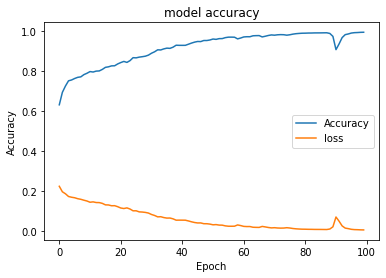

In [20]:
import matplotlib.pyplot as plt
plt.plot(history.history["accuracy"])
#plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","loss"])
plt.show()

In [21]:
eval_images=total_images[800:]
eval_labels=total_labels[800:]
eval_class_label=class_labels[800:]

In [22]:
from keras.models import load_model
from PIL import Image
images = eval_images
model = load_model("sbdn-shi-model.h5")
predictions=[]
heatmaps=[]
for i in range(images.shape[0]):
  img = images[i]
  img = img.astype(np.float32)/ 255.0
  img = np.expand_dims(img, -1)
  img = np.expand_dims(img, 0)
  pred = model.predict(img)
  predictions.append(pred)

1/1 [==============================] - 0s 21ms/step


In [23]:
len(predictions)

184

## **Evaluation with Shi et al (Chuk) Dataset**

## Instantiate Optimal Threshould for Evaluation Ground Truths

In [24]:
ground_truth_total=eval_labels/255.0
ground_truth_total=np.where(ground_truth_total>0.5,1.0,0.0)

## Mean Absolute Error

In [25]:
def get_mae(true_label, y_pred_label):
  absolute_error=[]
  for i in range(0,len(true_label)):
    #true_label = eval_labels[i]/255.0
    pp=np.where(((y_pred_label[i])[0])>0.5,1.0,0.0)
    y_pred=reshape(pp,[224,224])
    y_true=true_label[i]
    mae = tf.keras.losses.MeanAbsoluteError()
    m = mae(y_true, y_pred).numpy()
    absolute_error.append(m)
  return mean(absolute_error)
mean_absolute_error= get_mae(ground_truth_total,predictions)
print('Mean Absolute Error for Evaluation set: ',mean_absolute_error)

Mean Absolute Error for Evaluation set:  0.19570481470441436


## Precision Recall Graph

In [26]:
Y_ts_pred =reshape(predictions,[len(predictions),224,224])
Y_ts_pred = Y_ts_pred.reshape(Y_ts_pred.shape[0]*Y_ts_pred.shape[1]*Y_ts_pred.shape[2], 1)
print(Y_ts_pred.shape)
Y_ts = ground_truth_total.reshape(ground_truth_total.shape[0]*ground_truth_total.shape[1]*ground_truth_total.shape[2], 1)
print(Y_ts.shape)
Y_ts_pred = np.where(Y_ts_pred>0.5, 1, 0)
Y_ts  = np.where(Y_ts>0.5, 1, 0)

(9232384, 1)
(9232384, 1)



Area under Precision-Recall curve: 0.9040048560467484
Average Precision Scores: 0.8312125508140096


<Figure size 432x288 with 0 Axes>

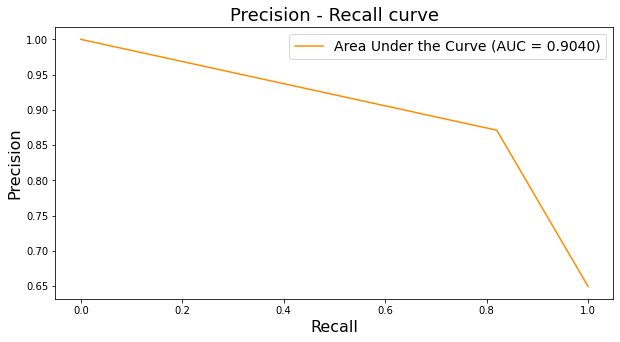

In [27]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
import numpy as np
import matplotlib.pyplot as plt
precision, recall, thresholds = precision_recall_curve(Y_ts, Y_ts_pred)
average_precision = average_precision_score(Y_ts, Y_ts_pred)
precision = np.fliplr([precision])[0]  #to avoid getting negative AUC)
recall = np.fliplr([recall])[0]  #to avoid getting negative AUC)
AUC_prec_rec = np.trapz(precision,recall)
print("\nArea under Precision-Recall curve: " +str(AUC_prec_rec))
prec_rec_curve = plt.figure()
plt.figure(figsize=(10,5))
plt.plot(recall,precision,'-',label='Area Under the Curve (AUC = %0.4f)' % AUC_prec_rec,color="darkorange")
plt.title('Precision - Recall curve',fontsize=18)
plt.xlabel("Recall",fontsize=16)
plt.ylabel("Precision",fontsize=16)
plt.legend(loc="best",prop={'size': 14})
plt.savefig("Precision_recall.png")
print("Average Precision Scores: " +str(average_precision))

In [28]:
beta2=0.3
fb=(1+beta2)*precision[1]*recall[1]/((beta2 * precision[1])+recall[1])
fb

0.8587595983264483

## Average Optimal Image Scale OIS-F score

In [29]:
from sklearn.metrics import precision_score,recall_score
threshoulds=[0.3,0.4,0.5,0.6,0.7]
beta2=0.2
def recall_precison(y_true,y_pred):
  OIS_F=[]
  Fb=[]
  for i in range(0,len(y_pred)):
    OIS_F_thr=[]
    fb_thr=[]
    for thr in threshoulds:
      pr=np.where(((y_pred[i])[0])>thr,1.0,0.0)
      pr=reshape(pr,[224,224])
      pred_precision_score=precision_score(y_true[i],pr, average='weighted')
      pred_recall_score=recall_score(y_true[i],pr, average='weighted')
      OIS=2*pred_precision_score*pred_recall_score/(pred_precision_score+pred_recall_score)
      fb=(1+beta2)*pred_precision_score*pred_recall_score/(beta2 * pred_precision_score+pred_recall_score)
      fb_thr.append(fb)
      OIS_F_thr.append(OIS)
    Fb.append(fb_thr)
    OIS_F.append(OIS_F_thr)
  return OIS_F,Fb

In [ ]:
OIS_array,Fb_array=recall_precison(ground_truth_total,predictions)

In [31]:
def Fb_score(Fb_array):
  best_Fb=[]
  for results in Fb_array:
    f_score=max(results)
    best_Fb.append(f_score)
  return np.nanmean(best_Fb)
mean_Fb_score= Fb_score(Fb_array)
print('Fb score: ',mean_Fb_score)

Fb score:  0.8491536200319388


In [32]:
def OIS_F_score(OIS_array):
  best_OIS_F=[]
  index_max=[]
  for results in OIS_array:
    f_score=max(results)
    best_OIS_F.append(f_score)
    index = results.index(f_score)
    index_max.append(index)
  return best_OIS_F,index_max
OIS_f1,indexes=OIS_F_score(OIS_array)
print('Average Optimal Image Scale F score: ',np.nanmean(OIS_f1))

Average Optimal Image Scale F score:  0.8214863856076142


## **Evaluation with DUT Dataset**

In [33]:
!unzip -qq dut500-source.zip

In [34]:
!unzip -qq dut500-gt.zip

In [35]:
from PIL import Image
img = Image.open('dut500-source/10.bmp')
new_img = img.resize( (224, 224) )
new_img.save( 'new.jpg')

In [ ]:
from PIL import Image
img = Image.open('dut500-gt/10.bmp')
new_img = img.resize( (224, 224) )
new_img.save( 'new.jpg')

In [36]:
from numpy import *
images_folder= "dut500-source/*.bmp"
labels_folder = "dut500-gt/"
def data_preprocessing(images_folder,labels_folder):
  total_img = []
  label = []
  files = glob.glob (images_folder)
  for myFile in files:
      image_name=os.path.split(myFile)[1]
      img = Image.open(myFile)
      new_img = img.resize( (224, 224))
      image = array(new_img)
      new_label=Image.open(labels_folder+image_name)
      new_label = new_label.resize((224, 224))
      label_image = array(new_label)
      label.append (label_image)
      total_img.append (image)
  total_img = np.array(total_img)
  label = np.array(label)
  label= np.reshape(label,[label.shape[0],label.shape[1],label.shape[2]])
  total_img= np.reshape(total_img,[total_img.shape[0],total_img.shape[1],total_img.shape[2],total_img.shape[3]])
  return label,total_img

In [37]:
DUT_labels,DUT_images=data_preprocessing(images_folder,labels_folder)

In [38]:
DUT_images.shape

(500, 224, 224, 3)

In [39]:
DUT_labels.shape

(500, 224, 224)

In [ ]:
from keras.models import load_model
from PIL import Image
images = DUT_images
model = load_model("sbdn-shi-model.h5")
predictions=[]
for i in range(images.shape[0]):
  img = images[i]
  img = img.astype(np.float32)/ 255.0
  img = np.expand_dims(img, -1)
  img = np.expand_dims(img, 0)
  pred = model.predict(img)
  predictions.append(pred)

In [41]:
ground_truth_total=DUT_labels/255.0
ground_truth_total=np.where(ground_truth_total>0.5,0.0,1.0)

In [42]:
def get_mae(true_label, y_pred_label):
  absolute_error=[]
  for i in range(0,len(true_label)):
    #true_label = eval_labels[i]/255.0
    pp=np.where(((y_pred_label[i])[0])>0.5,1.0,0.0)
    y_pred=reshape(pp,[224,224])
    y_true=true_label[i]
    mae = tf.keras.losses.MeanAbsoluteError()
    m = mae(y_true, y_pred).numpy()
    absolute_error.append(m)
  return mean(absolute_error)
mean_absolute_error= get_mae(ground_truth_total,predictions)
print('Mean Absolute Error for Evaluation set: ',mean_absolute_error)

Mean Absolute Error for Evaluation set:  0.1496114875637755


In [43]:
from sklearn.metrics import precision_score,recall_score
threshoulds=[0.3,0.4,0.5,0.6,0.7]
beta2=0.2
def recall_precison(y_true,y_pred):
  OIS_F=[]
  Fb=[]
  for i in range(0,len(y_pred)):
    OIS_F_thr=[]
    fb_thr=[]
    for thr in threshoulds:
      pr=np.where(((y_pred[i])[0])>thr,1.0,0.0)
      pr=reshape(pr,[224,224])
      pred_precision_score=precision_score(y_true[i],pr, average='weighted')
      pred_recall_score=recall_score(y_true[i],pr, average='weighted')
      OIS=2*pred_precision_score*pred_recall_score/(pred_precision_score+pred_recall_score)
      fb=(1+beta2)*pred_precision_score*pred_recall_score/(beta2 * pred_precision_score+pred_recall_score)
      fb_thr.append(fb)
      OIS_F_thr.append(OIS)
    Fb.append(fb_thr)
    OIS_F.append(OIS_F_thr)
  return OIS_F,Fb

In [ ]:
OIS_array,Fb_array=recall_precison(ground_truth_total,predictions)

In [45]:
def Fb_score(Fb_array):
  best_Fb=[]
  for results in Fb_array:
    f_score=max(results)
    best_Fb.append(f_score)
  return np.nanmean(best_Fb)
mean_Fb_score= Fb_score(Fb_array)
print('Fb score: ',mean_Fb_score)

Fb score:  0.9009388188872611


In [46]:
def OIS_F_score(OIS_array):
  best_OIS_F=[]
  index_max=[]
  for results in OIS_array:
    f_score=max(results)
    best_OIS_F.append(f_score)
    index = results.index(f_score)
    index_max.append(index)
  return best_OIS_F,index_max
OIS_f1,indexes=OIS_F_score(OIS_array)
print('Average Optimal Image Scale F score: ',np.nanmean(OIS_f1))

Average Optimal Image Scale F score:  0.9070562710596896


predicted class vs true class


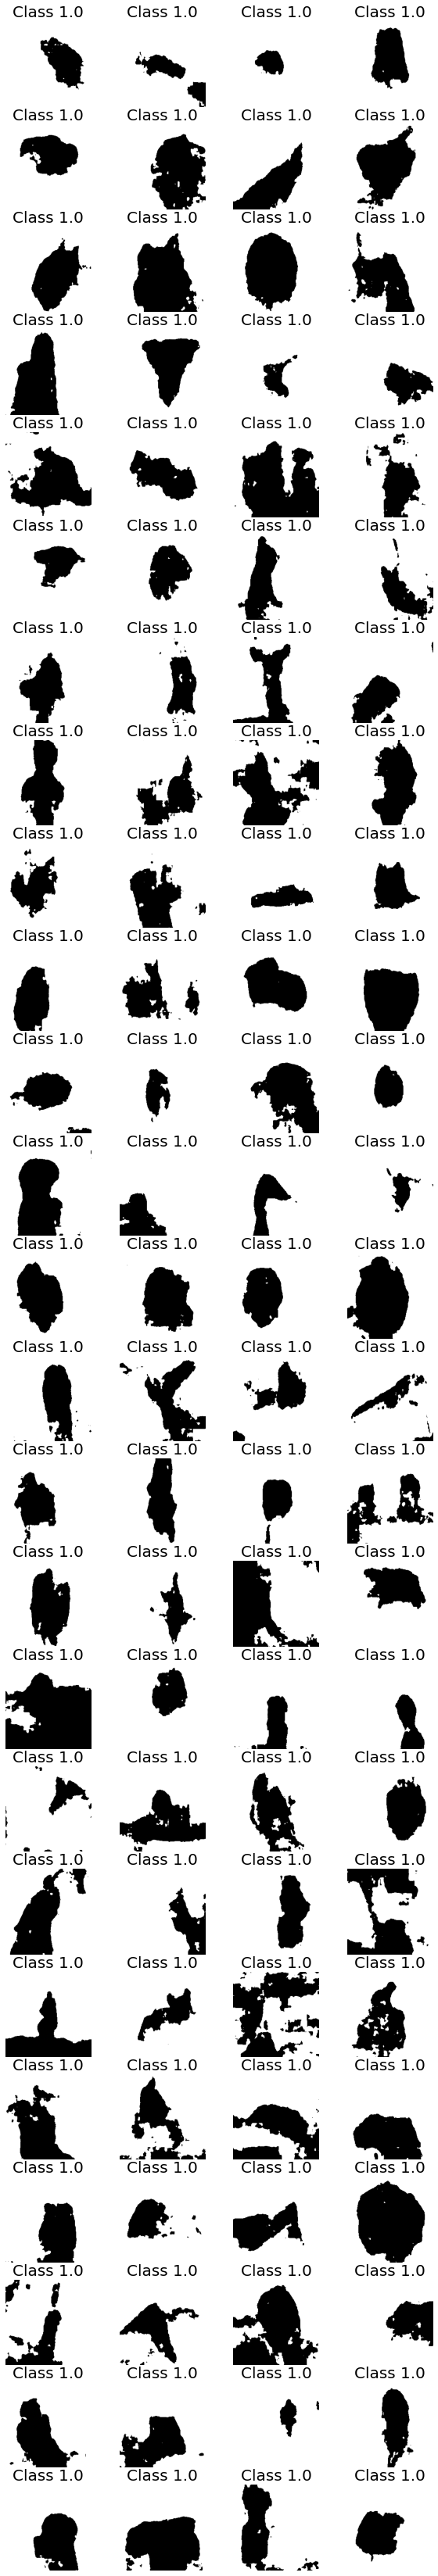

In [76]:
columns = 4
rows = 25
print("predicted class vs true class")
fig = plt.figure(figsize=(10,60))
for i in range(0, columns*rows):
  fig.add_subplot(rows, columns,i+1)
  img_pred_label = np.where(((predictions[i])[0])>0.5,0.1,0.0)
  #img_pred_label=(predictions[i])[0]
  plt.imshow(reshape(img_pred_label*255.0,[224,224]),cmap='gray')
  plt.title(f"Class {eval_class_label[i]}",fontsize=20)
  plt.axis("off")
plt.show()

predicted class vs true class


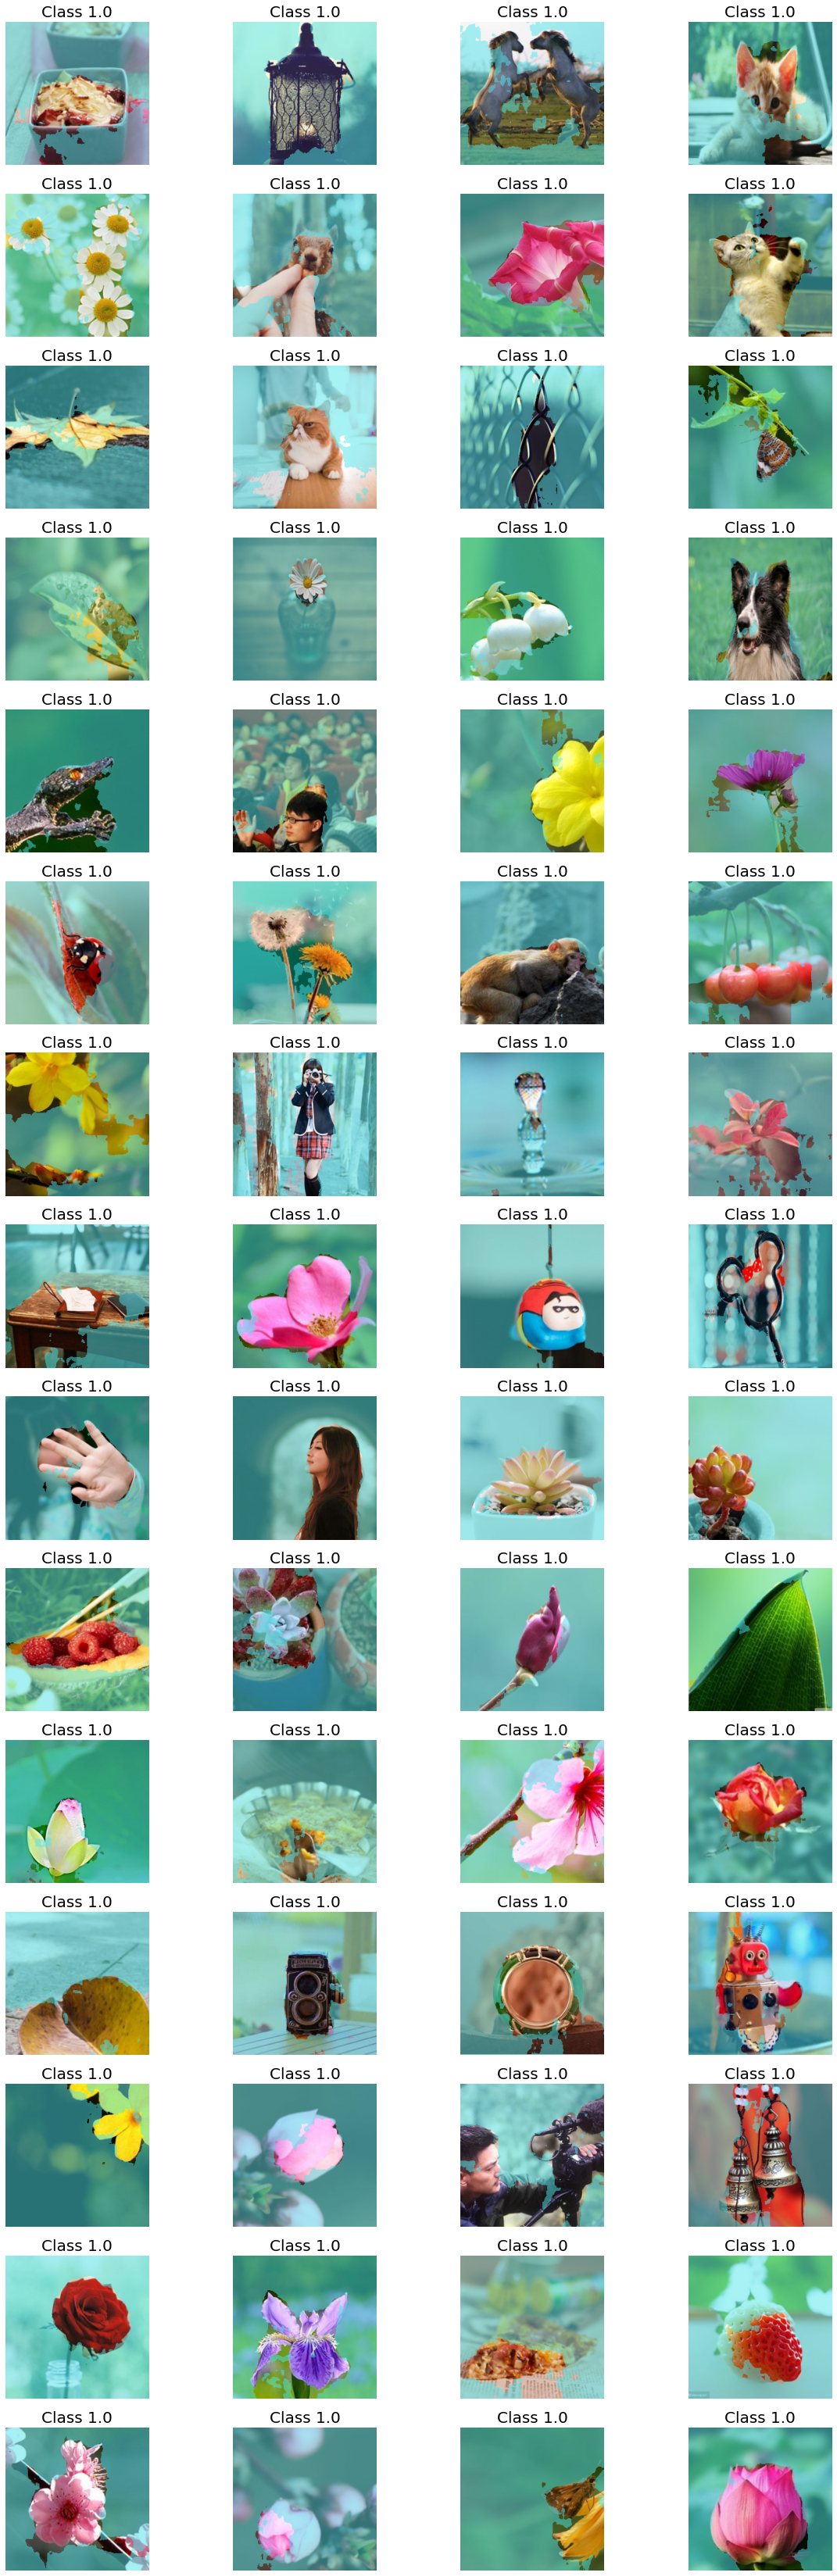

In [48]:
fig = plt.figure(figsize=(20,60))
columns = 4
rows = 15
print("predicted class vs true class")
for i in range(0, columns*rows):
  fig.add_subplot(rows, columns,i+1)
  img_pred_label = np.where((((predictions[i])[0]))>0.5,1.0,0.0)
  #img_pred_label=(predictions[i])[0]
  mask=(img_pred_label*255.0).astype(np.uint8)
  blackFrame = np.zeros((224,224, 3), dtype = "uint8")
  whiteFrame = 255 * np.ones((224,224,3), np.uint8)
  mask = np.where(mask==255,whiteFrame,blackFrame)
  img= images[i]
  cyan = np.full_like(img,(80, 229, 235))
  blend = 0.5
  img_cyan = cv2.addWeighted(img, blend, cyan, 1-blend, 0)
  mask = np.where(mask>=165,img_cyan,img)
  plt.imshow(mask,cmap='binary')
  plt.title(f"Class {eval_class_label[i]}",fontsize=20)
  plt.axis("off")
plt.show()

predicted class vs true class


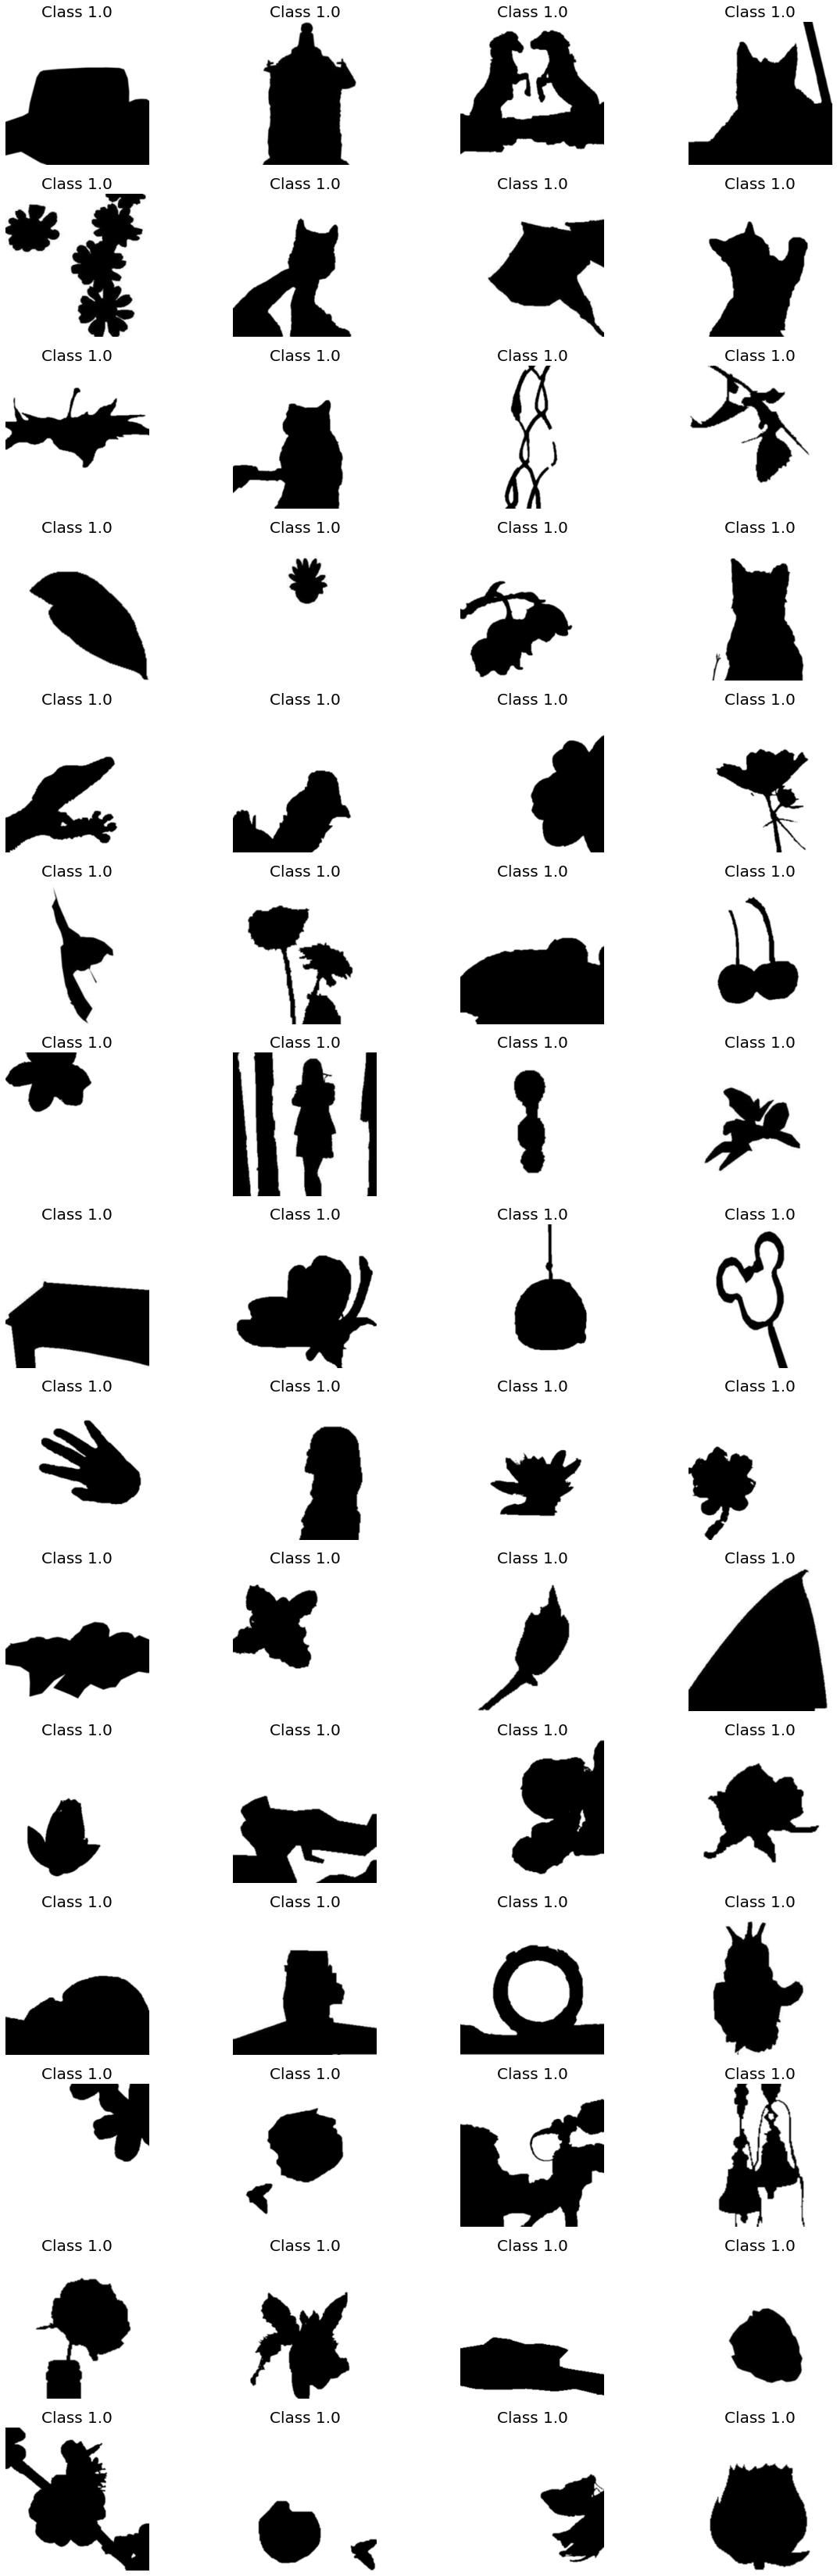

In [49]:
columns = 4
rows = 15
print("predicted class vs true class")
fig = plt.figure(figsize=(20,60))
for i in range(0, columns*rows):
  fig.add_subplot(rows, columns,i+1)
  plt.imshow(DUT_labels[i],cmap='binary')
  plt.title(f"Class {eval_class_label[i]}",fontsize=20)
  plt.axis("off")
plt.show()

## **Evaluation with SZU-DB Dataset**

In [50]:
!unzip -qq img.zip

In [51]:
!unzip -qq gt.zip

In [56]:
from numpy import *
images_folder= "img/*.jpg"
labels_folder = "gt/"
def data_preprocessing(images_folder,labels_folder):
  total_img = []
  label = []
  files = glob.glob (images_folder)
  for myFile in files:
      image_name=os.path.split(myFile)[1]
      img = Image.open(myFile)
      new_img = img.resize( (224, 224))
      image = array(new_img)
      image_name=image_name[:-3]
      image_name=image_name+'png'
      new_label=Image.open(labels_folder+image_name)
      new_label = new_label.resize((224, 224))
      label_image = array(new_label)
      label.append (label_image)
      total_img.append (image)
  total_img = np.array(total_img)
  label = np.array(label)
  label= np.reshape(label,[label.shape[0],label.shape[1],label.shape[2]])
  total_img= np.reshape(total_img,[total_img.shape[0],total_img.shape[1],total_img.shape[2],total_img.shape[3]])
  return label,total_img

In [57]:
SZU_labels,SZU_images=data_preprocessing(images_folder,labels_folder)

In [58]:
SZU_images.shape

(784, 224, 224, 3)

In [59]:
SZU_labels.shape

(784, 224, 224)

In [ ]:
images = SZU_images
predictions=[]
for i in range(images.shape[0]):
  img = images[i]
  img = img.astype(np.float32)/ 255.0
  img = np.expand_dims(img, -1)
  img = np.expand_dims(img, 0)
  pred = model.predict(img)
  predictions.append(pred)

In [67]:
ground_truth_total=SZU_labels/255.0
ground_truth_total=np.where(ground_truth_total>0.5,1.0,0.0)

In [68]:
def get_mae(true_label, y_pred_label):
  absolute_error=[]
  for i in range(0,len(true_label)):
    #true_label = eval_labels[i]/255.0
    pp=np.where(((y_pred_label[i])[0])>0.5,1.0,0.0)
    y_pred=reshape(pp,[224,224])
    y_true=true_label[i]
    mae = tf.keras.losses.MeanAbsoluteError()
    m = mae(y_true, y_pred).numpy()
    absolute_error.append(m)
  return mean(absolute_error)
mean_absolute_error= get_mae(ground_truth_total,predictions)
print('Mean Absolute Error for Evaluation set: ',mean_absolute_error)

Mean Absolute Error for Evaluation set:  0.11324594061556384


In [69]:
from sklearn.metrics import precision_score,recall_score
threshoulds=[0.3,0.4,0.5,0.6,0.7]
beta2=0.2
def recall_precison(y_true,y_pred):
  OIS_F=[]
  Fb=[]
  for i in range(0,len(y_pred)):
    OIS_F_thr=[]
    fb_thr=[]
    for thr in threshoulds:
      pr=np.where(((y_pred[i])[0])>thr,1.0,0.0)
      pr=reshape(pr,[224,224])
      pred_precision_score=precision_score(y_true[i],pr, average='weighted')
      pred_recall_score=recall_score(y_true[i],pr, average='weighted')
      OIS=2*pred_precision_score*pred_recall_score/(pred_precision_score+pred_recall_score)
      fb=(1+beta2)*pred_precision_score*pred_recall_score/(beta2 * pred_precision_score+pred_recall_score)
      fb_thr.append(fb)
      OIS_F_thr.append(OIS)
    Fb.append(fb_thr)
    OIS_F.append(OIS_F_thr)
  return OIS_F,Fb

In [ ]:
OIS_array,Fb_array=recall_precison(ground_truth_total,predictions)

In [71]:
def Fb_score(Fb_array):
  best_Fb=[]
  for results in Fb_array:
    f_score=max(results)
    best_Fb.append(f_score)
  return np.nanmean(best_Fb)
mean_Fb_score= Fb_score(Fb_array)
print('Fb score: ',mean_Fb_score)

Fb score:  0.9426389906586774


In [72]:
def OIS_F_score(OIS_array):
  best_OIS_F=[]
  index_max=[]
  for results in OIS_array:
    f_score=max(results)
    best_OIS_F.append(f_score)
    index = results.index(f_score)
    index_max.append(index)
  return best_OIS_F,index_max
OIS_f1,indexes=OIS_F_score(OIS_array)
print('Average Optimal Image Scale F score: ',np.nanmean(OIS_f1))

Average Optimal Image Scale F score:  0.9230469736979832


In [73]:
Y_ts_pred =reshape(predictions,[len(predictions),224,224])
Y_ts_pred = Y_ts_pred.reshape(Y_ts_pred.shape[0]*Y_ts_pred.shape[1]*Y_ts_pred.shape[2], 1)
print(Y_ts_pred.shape)
Y_ts = ground_truth_total.reshape(ground_truth_total.shape[0]*ground_truth_total.shape[1]*ground_truth_total.shape[2], 1)
print(Y_ts.shape)
Y_ts_pred = np.where(Y_ts_pred>0.5, 1, 0)
Y_ts  = np.where(Y_ts>0.5, 1, 0)

(39337984, 1)
(39337984, 1)



Area under Precision-Recall curve: 0.9622609928783452
Average Precision Scores: 0.9296793142565632


<Figure size 432x288 with 0 Axes>

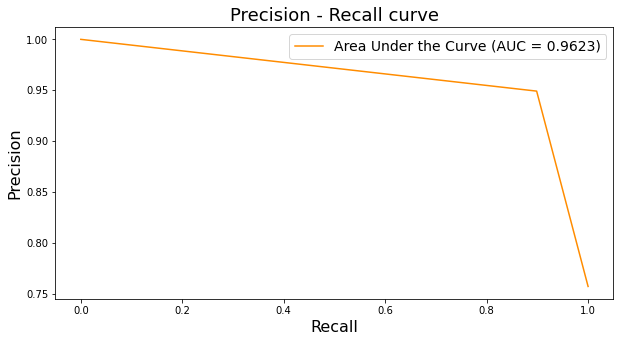

In [74]:
precision, recall, thresholds = precision_recall_curve(Y_ts, Y_ts_pred)
average_precision = average_precision_score(Y_ts, Y_ts_pred)
precision = np.fliplr([precision])[0]  #to avoid getting negative AUC)
recall = np.fliplr([recall])[0]  #to avoid getting negative AUC)
AUC_prec_rec = np.trapz(precision,recall)
print("\nArea under Precision-Recall curve: " +str(AUC_prec_rec))
prec_rec_curve = plt.figure()
plt.figure(figsize=(10,5))
plt.plot(recall,precision,'-',label='Area Under the Curve (AUC = %0.4f)' % AUC_prec_rec,color="darkorange")
plt.title('Precision - Recall curve',fontsize=18)
plt.xlabel("Recall",fontsize=16)
plt.ylabel("Precision",fontsize=16)
plt.legend(loc="best",prop={'size': 14})
plt.savefig("Precision_recall.png")
print("Average Precision Scores: " +str(average_precision))

In [75]:
beta2=0.3
fb=(1+beta2)*precision[1]*recall[1]/((beta2 * precision[1])+recall[1])
fb

0.9369785297734242

predicted class vs true class


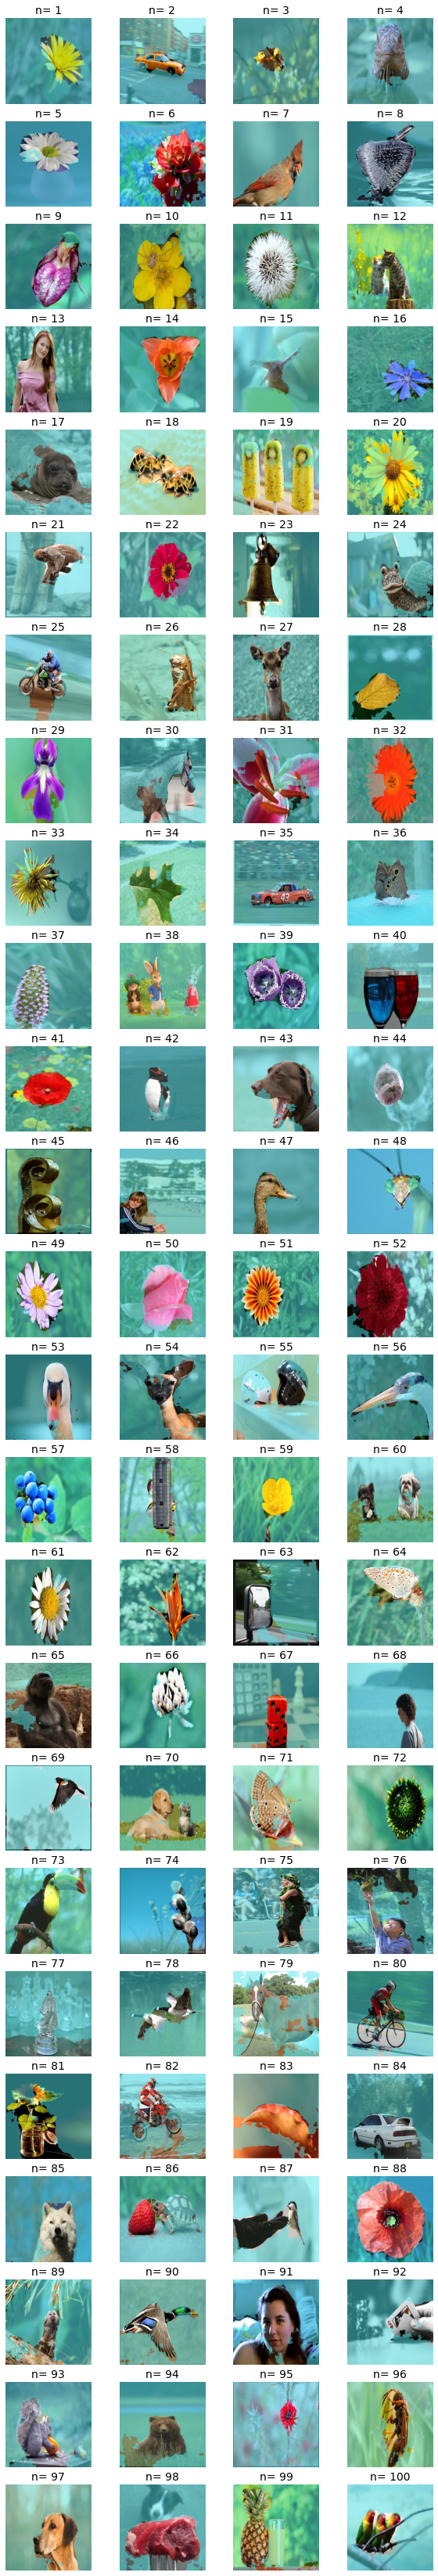

In [80]:
fig = plt.figure(figsize=(10,60))
columns = 4
rows = 25
print("predicted class vs true class")
for i in range(0, columns*rows):
  fig.add_subplot(rows, columns,i+1)
  img_pred_label = np.where((((predictions[i])[0]))>0.5,1.0,0.0)
  #img_pred_label=(predictions[i])[0]
  mask=(img_pred_label*255.0).astype(np.uint8)
  blackFrame = np.zeros((224,224, 3), dtype = "uint8")
  whiteFrame = 255 * np.ones((224,224,3), np.uint8)
  mask = np.where(mask==255,whiteFrame,blackFrame)
  img= images[i]
  cyan = np.full_like(img,(80, 229, 235))
  blend = 0.5
  img_cyan = cv2.addWeighted(img, blend, cyan, 1-blend, 0)
  mask = np.where(mask>=165,img_cyan,img)
  plt.imshow(mask,cmap='binary')
  plt.title(f"n= {i+1}",fontsize=14)
  plt.axis("off")
plt.show()

predicted class vs true class


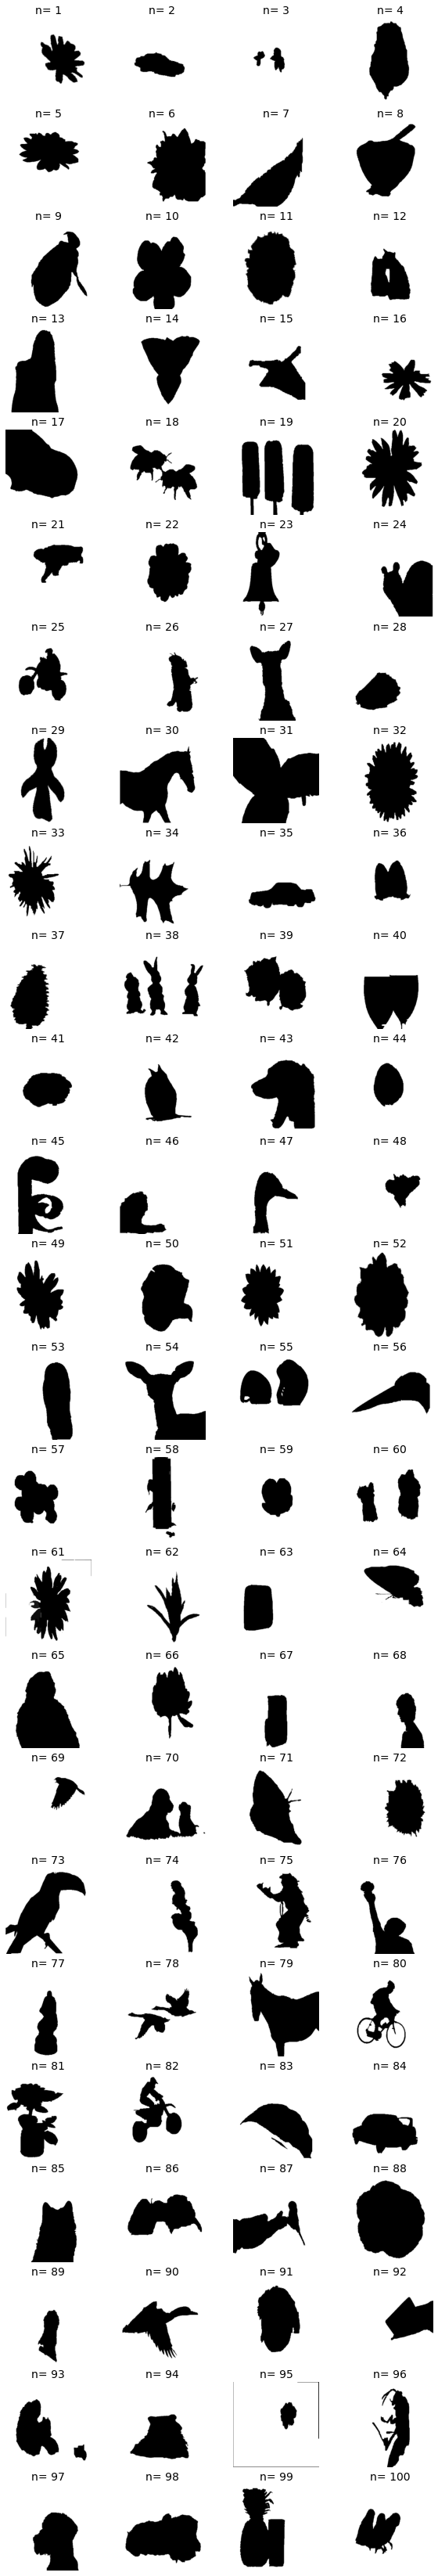

In [82]:
columns = 4
rows = 25
print("predicted class vs true class")
fig = plt.figure(figsize=(10,60))
for i in range(0, columns*rows):
  fig.add_subplot(rows, columns,i+1)
  plt.imshow(SZU_labels[i],cmap='gray')
  plt.title(f"n= {i+1}",fontsize=14)
  plt.axis("off")
plt.show()

predicted class vs true class


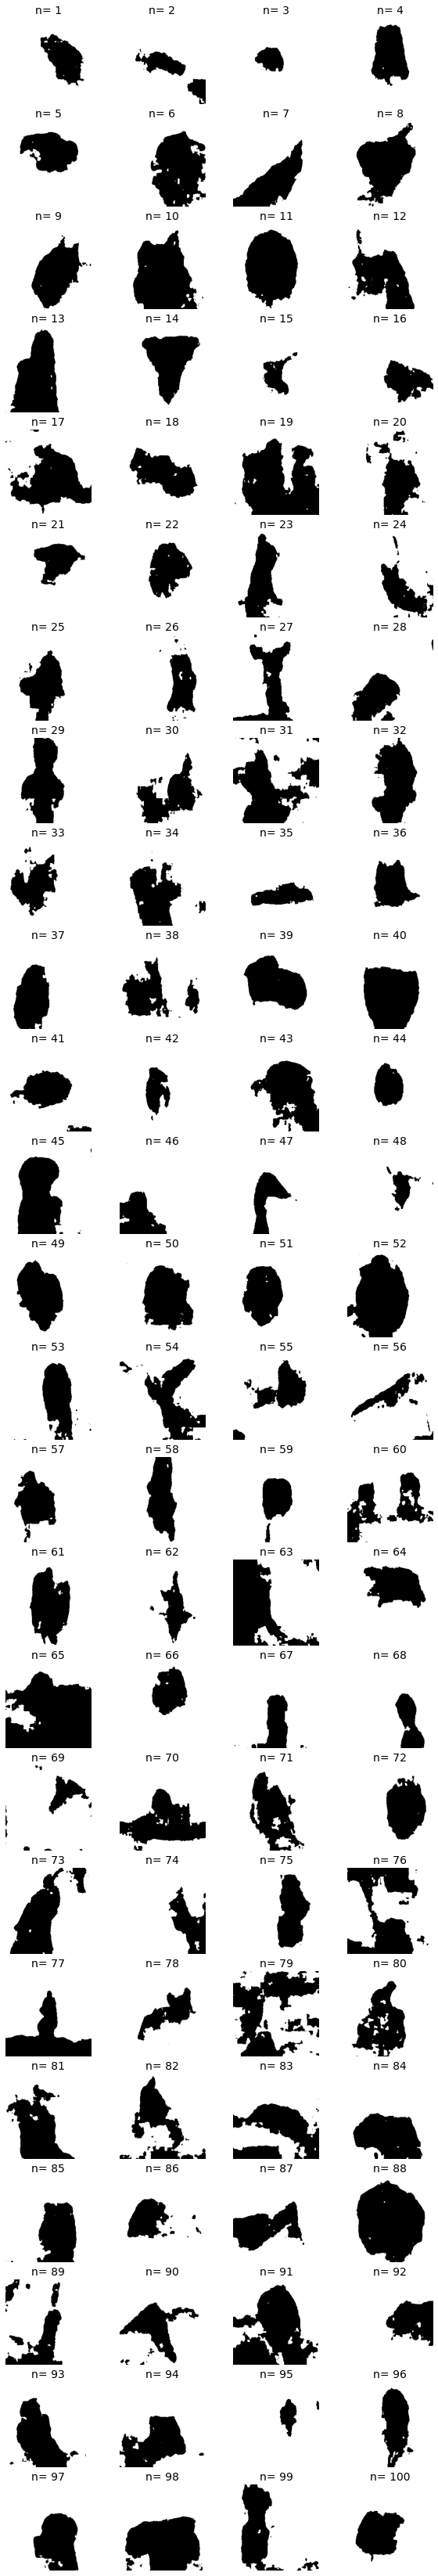

In [86]:
columns = 4
rows = 25
print("predicted class vs true class")
fig = plt.figure(figsize=(10,60))
for i in range(0, columns*rows):
  fig.add_subplot(rows, columns,i+1)
  img_pred_label = np.where(((predictions[i])[0])>0.5,0.1,0.0)
  #img_pred_label=(predictions[i])[0]
  plt.imshow(reshape(img_pred_label*255.0,[224,224]),cmap='gray')
  plt.title(f"n= {i+1}",fontsize=14)
  plt.axis("off")
plt.show()